# Import libraries

In [0]:
import os
import time
import datetime
import string
import random
import math
import json
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**List the devices available to tensorflow**

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18210768129148261017, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11297803469
 locality {
   bus_id: 1
 }
 incarnation: 3680785508017395591
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
!pip install --upgrade gensim
from gensim.models.word2vec import Word2VecKeyedVectors

    100% |████████████████████████████████| 22.6MB 60kB/s 
    100% |████████████████████████████████| 50.0MB 28kB/s 
Requirement already up-to-date: six>=1.5.0 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: numpy>=1.11.3 in /usr/local/lib/python3.6/dist-packages (from gensim)
    100% |████████████████████████████████| 133kB 8.7MB/s 
    100% |████████████████████████████████| 1.4MB 950kB/s 
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
    100% |████████████████████████████████| 61kB 8.8MB/s 
    100% |████████████████████████████████| 4.1MB 324kB/s 
Requirement already up-to-date: certifi>=2017.4.17 in /usr/local/lib/python3.6/dist-packages (from requests->smart-open>=1.2.1->gensim)
Requirement already up-to-date: idna<2.7,>=2.5 in /usr/local/lib/python3.6/dist-packages (from requests->smart-open>=1.2.1->gensim)
Requirement already up-to-date: urllib3<1.23,>=1.21.1 in /usr/

**Make the result reproducible by setting the seed of numpy and tensorflow**

In [4]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


# Load the cleaned data

**Authentication via google auth**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Upload a file from google cloud where file ids are stored as a json**

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

file_id_data= json.loads(uploaded['file_id.json'])

Saving file_id.json to file_id.json
User uploaded file "file_id.json" with length 489 bytes


**Download files to the kernel**

In [0]:
downloaded1 = drive.CreateFile({'id':file_id_data["modified_train_file_id"]}) 
downloaded1.GetContentFile('modified_train_data.csv')  
downloaded2 = drive.CreateFile({'id':file_id_data["modified_test_file_id"]}) 
downloaded2.GetContentFile('modified_test_data.csv')
downloaded3 = drive.CreateFile({'id':file_id_data["word2vec_model"]}) 
downloaded3.GetContentFile('word2vec_model')  
downloaded4 = drive.CreateFile({'id':file_id_data["data"]}) 
downloaded4.GetContentFile('data.json')

**Load train and test data to notebook**

In [0]:
#3. Read file as panda dataframe
data = pd.read_csv('modified_train_data.csv') 
test_data = pd.read_csv('modified_test_data.csv')

**Remove the csv files from kernel**

In [0]:
os.remove("modified_train_data.csv")
os.remove("modified_test_data.csv")

**Extract size from the json file**

In [0]:
metadata= json.loads(open("data.json").read())
size = metadata['size']

**Extract the size of Word2Vec model**

In [0]:
fname = "word2vec_model"
model = Word2VecKeyedVectors.load_word2vec_format(fname)

In [0]:
os.remove("word2vec_model")

# Inspect the distribution of #words in the sentences

**Distribution of #words in train data**

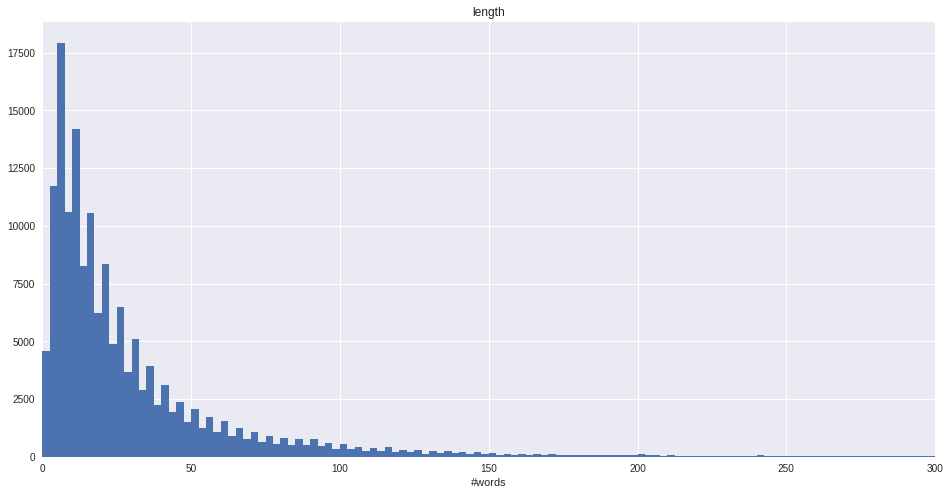

In [13]:
data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in test data**

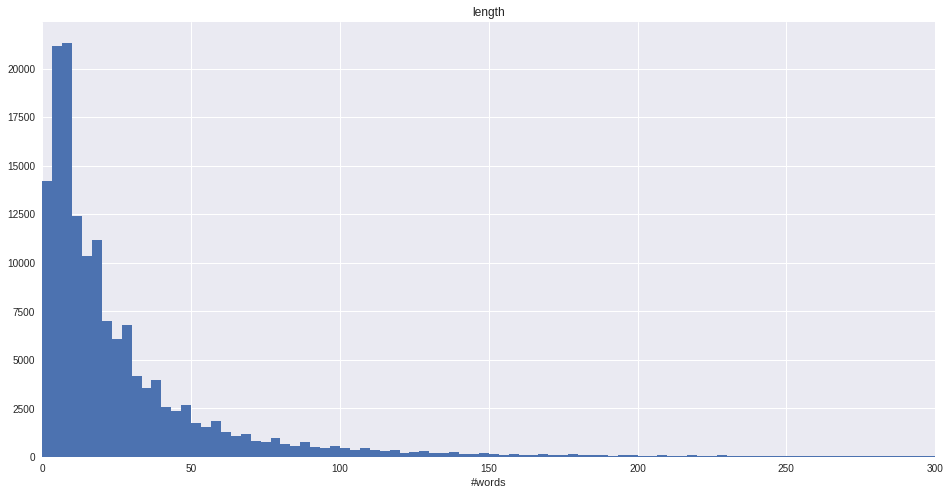

In [14]:
test_data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in all data**

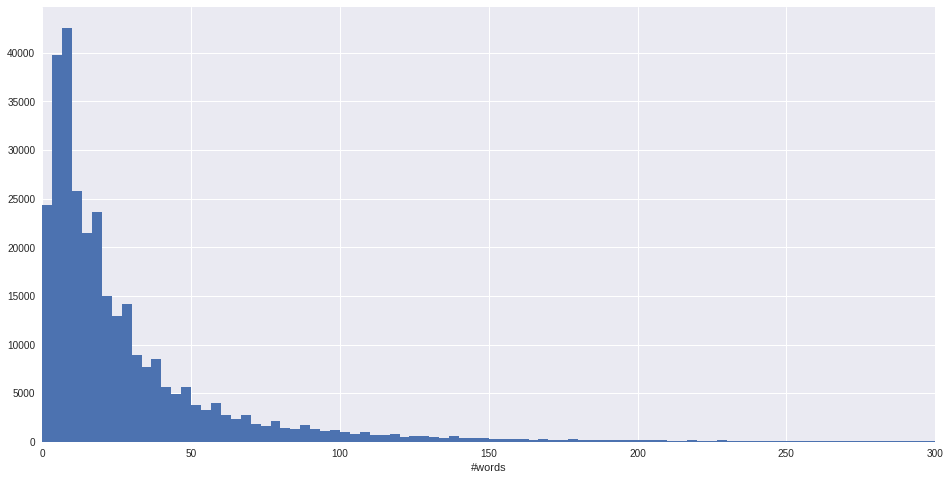

In [15]:
all_length = pd.concat([data['length'], test_data['length']])
all_length.hist(bins=500, figsize=(16,8))
plt.xlim(0,300)
plt.xlabel("#words")
plt.show()
del(all_length)

# Train validation split

**Extract the train, validation, and test data in numpy arrays**

In [0]:
comments = data["comment_text"].as_matrix()
sentiments = data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].as_matrix()
seq_length = data['length'].as_matrix()

# randomly generate train and validation indices
train_indices = np.random.choice(len(seq_length), round(len(seq_length)*0.96), replace=False)
validation_indices = np.array(list(set(range(len(seq_length))) - set(train_indices)))

comments_train = comments[train_indices]
comments_validation = comments[validation_indices]
comments_test = test_data["comment_text"].as_matrix()

seq_length_train = seq_length[train_indices]
seq_length_validation = seq_length[validation_indices]
seq_length_test = test_data['length'].as_matrix()

sentiments_train = sentiments[train_indices]
sentiments_validation = sentiments[validation_indices]

test_id = test_data['id'].as_matrix()

In [17]:
print("shape of comments_train:",comments_train.shape)
print("shape of comments_validation:",comments_validation.shape)
print("shape of comments_test:",comments_test.shape)
print("shape of seq_length_train:",seq_length_train.shape)
print("shape of seq_length_validation:",seq_length_validation.shape)
print("shape of seq_length_test:",seq_length_test.shape)
print("shape of sentiments_train:",sentiments_train.shape)
print("shape of sentiments_test:",sentiments_validation.shape)
print("shape of test_id:",test_id.shape)

shape of comments_train: (153188,)
shape of comments_validation: (6383,)
shape of comments_test: (153164,)
shape of seq_length_train: (153188,)
shape of seq_length_validation: (6383,)
shape of seq_length_test: (153164,)
shape of sentiments_train: (153188, 6)
shape of sentiments_test: (6383, 6)
shape of test_id: (153164,)


In [0]:
del(train_indices, validation_indices, data, test_data, comments, sentiments, seq_length)

# Create Recurrent Neural Network (LSTM cell)

**A function to generate fixed length sequence**

In [0]:
def sequence_generator(comments, max_length, size):
    
    sentences = []
    for comment in comments.tolist():
        sentences.append(str(comment).split())
        
    sequences = []
    for sentence in sentences:
        if len(sentence)>0:
            if len(sentence)<max_length:
                sequence = model[sentence]
                tail = np.zeros((max_length - len(sentence), size))
                sequence = np.concatenate((sequence, tail))
            else:
                sequence = model[sentence[:max_length]]
        else:
            sequence = np.zeros((max_length, size))        
        sequences.append(sequence)
    sequences = np.array(sequences)
    
    return sequences

**Parameters of sequence data**

In [0]:
max_length = n_steps = 300 
size = n_inputs = size
n_outputs = 6

**Function to generate batch data**

In [0]:
def generate_train_batch(indices, comments, seq_length, sentiments, max_length, size):
    
    comments_batch = comments[indices]
    seq_length_batch = seq_length[indices]
    sentiments_batch = sentiments[indices]
    
    sequences_batch = sequence_generator(comments_batch, max_length, size)
    
    return sequences_batch, seq_length_batch, sentiments_batch

**Placeholders**

In [0]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
labels = tf.placeholder(tf.float32, [None, n_outputs])
length = tf.placeholder(tf.int32, [None])
keep_prob = tf.placeholder(tf.float32)

## Creat RNN layer

**Create a multilayered lstm network**

In [0]:
n_layers = 2
n_neurons = 256

In [0]:
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
lstm_cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
                    for cell in lstm_cells]
cells_across_gpu = [tf.contrib.rnn.DeviceWrapper("/device:GPU:0", cell) for cell in lstm_cells_drop]

multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

**Extract the short term output of the last lstm cell**

In [25]:
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32, sequence_length=length)
top_layer_h_state = states[-1][1]
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 256) dtype=float32>

## Create fully connected layers

**Functions to create weights and biases**

In [0]:
def create_weights(shape):
    '''a function to create weight tensor'''
    with tf.device("/device:CPU:0"):
        W = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    return W

def create_biases(size):
    '''a function to create bias tensor'''
    with tf.device("/device:CPU:0"):
        b = tf.Variable(tf.constant(0.05, shape=[size]))
    return b

**Function to create fully connected layer**

In [0]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=False,
                    dropout = False, 
                    keep_prob = 0.2):
    
    '''a function for creating fully connected layer'''
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    with tf.device("/device:GPU:0"):
      # matrix multiplication between input and weight matrix
      layer = tf.matmul(input, weights)

      # add the bias to the convolutional layer
      layer += biases

      # add relu activation if wanted
      if use_relu:
          layer = tf.nn.relu(layer)

      # if dropout is wanted add dropout
      if dropout:        
          layer = tf.nn.dropout(layer, keep_prob)

    # return layer
    return layer

**Create fully connected layer**

In [0]:
fc_layer_size1 = 36
# fc_layer_size2 = 64

In [29]:
layer_fc1 = create_fc_layer(input=top_layer_h_state,
                            num_inputs=top_layer_h_state.get_shape()[1].value,
                            num_outputs=fc_layer_size1,
                            use_relu=True,
                            dropout =True,
                            keep_prob = keep_prob)
layer_fc1

<tf.Tensor 'dropout/mul:0' shape=(?, 36) dtype=float32>

In [0]:
# layer_fc2 = create_fc_layer(input=layer_fc1,
#                             num_inputs=fc_layer_size1,
#                             num_outputs=fc_layer_size2,
#                             use_relu=True,
#                             dropout =True,
#                             keep_prob = keep_prob)
# layer_fc2

**Create output layer**

In [31]:
output = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size1,
                            num_outputs=n_outputs,
                            use_relu=False,
                            dropout =False)
output

<tf.Tensor 'add_1:0' shape=(?, 6) dtype=float32>

**Sigmoid of the output**

In [32]:
with tf.device("/device:GPU:0"):
    logits = tf.nn.sigmoid(output)
logits

<tf.Tensor 'Sigmoid:0' shape=(?, 6) dtype=float32>

## Create optimization operation

**Loss operation**

In [0]:
with tf.device("/device:GPU:0"):
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=output)

**ROC AUC calculation operations**

In [0]:
roc = tf.metrics.auc(labels=labels, predictions=logits)

**Train step**

In [0]:
# learning rate of optimizer
learning_rate = (1e-2)*.7
with tf.device("/device:GPU:0"):
  # train step
  train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Train the model

In [0]:
# lists to store the train loss, validation loss, validation accuracy at each iteration
train_loss = []
valid_loss = []
valid_roc = []

# batch size
batch_size = 200
# max iteration
max_iter = 5000

**Train model for few hours and save the best model along the way**

In [37]:
# create a saver object
saver = tf.train.Saver(max_to_keep=1)

# variables to store the accuracy, loss, iteration of our best model
best_accuracy = 0
best_roc = -10
best_iteration = None

iteration = 0

train_hours = 4.5

# feed dictionary for validation
feed_dict_validation =  {X:sequence_generator(comments_validation, max_length, size),
                        labels:sentiments_validation,
                        length:seq_length_validation,
                        keep_prob: 1.0}

t1 = time.time()

# create a graph session and optimize under it
with tf.Session() as sess:
    
    # initialize variables
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    # while minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < train_hours*60*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        # randomly choosing the indices of the batch 
        rand_index = np.random.choice(sentiments_train.shape[0], size=batch_size)

        # extract the batch data
        sequences_batch, seq_length_batch, sentiments_batch = \
        generate_train_batch(rand_index, comments_train, seq_length_train, sentiments_train,
                             max_length, size)
        
        # feed dictionary for batch
        feed_dict_batch =  {X:sequences_batch,
                            labels:sentiments_batch,
                            length:seq_length_batch,
                            keep_prob: 0.75}
        # feed dictionary for train
        feed_dict_train =  {X:sequences_batch,
                            labels:sentiments_batch,
                            length:seq_length_batch,
                            keep_prob: 1.0}        
        
        # execute optimization step
        sess.run(train_step, feed_dict=feed_dict_batch)

        # calculate temporary train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)
        # calculate temporary validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        # calculate roc score
        temp_roc_score = sess.run(roc, feed_dict=feed_dict_validation)[1]
        valid_roc.append(temp_roc_score)
        
        # if valid loss is better than best recorded so far then
        # update the parameters of the best model and save the model
        if temp_roc_score > best_roc:
            best_roc = temp_roc_score
            best_iteration = iteration          
            saver.save(sess, './my-model', global_step = best_iteration)

        # print metric info
        print("iterations:",iteration,
              "| train_loss:", temp_train_loss,
              "| validation_loss:", temp_validation_loss,
              "| Roc Score:", temp_roc_score,
              "| Time elapsed:",str(datetime.timedelta(seconds=time.time()-t1)))
        
        # increment iteration
        iteration = iteration+1

iterations: 0 | train_loss: 0.60234976 | validation_loss: 0.6075843 | Roc Score: 0.636173 | Time elapsed: 0:00:09.551092
iterations: 1 | train_loss: 0.35853204 | validation_loss: 0.37167764 | Roc Score: 0.5516465 | Time elapsed: 0:00:18.367991
iterations: 2 | train_loss: 0.21531177 | validation_loss: 0.22367182 | Roc Score: 0.5288934 | Time elapsed: 0:00:27.082225
iterations: 3 | train_loss: 0.13953276 | validation_loss: 0.16693705 | Roc Score: 0.51799965 | Time elapsed: 0:00:36.152953
iterations: 4 | train_loss: 0.14412381 | validation_loss: 0.1691006 | Roc Score: 0.51380664 | Time elapsed: 0:00:45.484502
iterations: 5 | train_loss: 0.17070566 | validation_loss: 0.18390256 | Roc Score: 0.5166882 | Time elapsed: 0:00:54.260804
iterations: 6 | train_loss: 0.19353047 | validation_loss: 0.18964165 | Roc Score: 0.5255707 | Time elapsed: 0:01:02.986751
iterations: 7 | train_loss: 0.1622626 | validation_loss: 0.18779571 | Roc Score: 0.53531206 | Time elapsed: 0:01:12.086702
iterations: 8 | t

iterations: 39 | train_loss: 0.14257209 | validation_loss: 0.11786807 | Roc Score: 0.7052694 | Time elapsed: 0:05:54.451879
iterations: 40 | train_loss: 0.15707175 | validation_loss: 0.11844187 | Roc Score: 0.7087075 | Time elapsed: 0:06:03.621896
iterations: 41 | train_loss: 0.124238685 | validation_loss: 0.11794324 | Roc Score: 0.7120808 | Time elapsed: 0:06:12.717263
iterations: 42 | train_loss: 0.112851344 | validation_loss: 0.11851822 | Roc Score: 0.7152683 | Time elapsed: 0:06:21.765548
iterations: 43 | train_loss: 0.12008084 | validation_loss: 0.11896708 | Roc Score: 0.718264 | Time elapsed: 0:06:31.067335
iterations: 44 | train_loss: 0.109966904 | validation_loss: 0.11997702 | Roc Score: 0.721089 | Time elapsed: 0:06:39.395199
iterations: 45 | train_loss: 0.13571772 | validation_loss: 0.11996499 | Roc Score: 0.7239186 | Time elapsed: 0:06:47.267256
iterations: 46 | train_loss: 0.116654254 | validation_loss: 0.12182205 | Roc Score: 0.72658724 | Time elapsed: 0:06:55.228481
itera

iterations: 78 | train_loss: 0.10829346 | validation_loss: 0.10169188 | Roc Score: 0.78323436 | Time elapsed: 0:11:31.920833
iterations: 79 | train_loss: 0.11229314 | validation_loss: 0.10260946 | Roc Score: 0.7846279 | Time elapsed: 0:11:41.000087
iterations: 80 | train_loss: 0.09919108 | validation_loss: 0.10102238 | Roc Score: 0.7860562 | Time elapsed: 0:11:49.915057
iterations: 81 | train_loss: 0.111012876 | validation_loss: 0.09883718 | Roc Score: 0.7875279 | Time elapsed: 0:11:59.216120
iterations: 82 | train_loss: 0.09737064 | validation_loss: 0.097294435 | Roc Score: 0.78908783 | Time elapsed: 0:12:08.370946
iterations: 83 | train_loss: 0.100853756 | validation_loss: 0.10026695 | Roc Score: 0.7906459 | Time elapsed: 0:12:17.233051
iterations: 84 | train_loss: 0.1042306 | validation_loss: 0.096363604 | Roc Score: 0.7922646 | Time elapsed: 0:12:26.246543
iterations: 85 | train_loss: 0.12528962 | validation_loss: 0.092796445 | Roc Score: 0.79388165 | Time elapsed: 0:12:35.326626
i

iterations: 117 | train_loss: 0.0947258 | validation_loss: 0.07243033 | Roc Score: 0.84192914 | Time elapsed: 0:17:14.937743
iterations: 118 | train_loss: 0.056269422 | validation_loss: 0.066368364 | Roc Score: 0.84330314 | Time elapsed: 0:17:24.159552
iterations: 119 | train_loss: 0.082187995 | validation_loss: 0.070379645 | Roc Score: 0.84455794 | Time elapsed: 0:17:33.487968
iterations: 120 | train_loss: 0.051905733 | validation_loss: 0.07834758 | Roc Score: 0.84557074 | Time elapsed: 0:17:41.920905
iterations: 121 | train_loss: 0.054777604 | validation_loss: 0.08127383 | Roc Score: 0.84647053 | Time elapsed: 0:17:49.953323
iterations: 122 | train_loss: 0.079867646 | validation_loss: 0.06956034 | Roc Score: 0.8476399 | Time elapsed: 0:17:58.880354
iterations: 123 | train_loss: 0.08093467 | validation_loss: 0.0708751 | Roc Score: 0.8488587 | Time elapsed: 0:18:07.756257
iterations: 124 | train_loss: 0.08815233 | validation_loss: 0.09307096 | Roc Score: 0.84981275 | Time elapsed: 0:18

iterations: 156 | train_loss: 0.051562943 | validation_loss: 0.062219825 | Roc Score: 0.8788486 | Time elapsed: 0:23:02.445543
iterations: 157 | train_loss: 0.09218928 | validation_loss: 0.06299859 | Roc Score: 0.8795921 | Time elapsed: 0:23:11.009806
iterations: 158 | train_loss: 0.066063605 | validation_loss: 0.07752556 | Roc Score: 0.8801901 | Time elapsed: 0:23:19.561708
iterations: 159 | train_loss: 0.071962774 | validation_loss: 0.075563036 | Roc Score: 0.8808074 | Time elapsed: 0:23:28.940467
iterations: 160 | train_loss: 0.062050253 | validation_loss: 0.06297923 | Roc Score: 0.88153833 | Time elapsed: 0:23:37.362170
iterations: 161 | train_loss: 0.09996655 | validation_loss: 0.058681212 | Roc Score: 0.88230366 | Time elapsed: 0:23:46.277443
iterations: 162 | train_loss: 0.07344679 | validation_loss: 0.06201655 | Roc Score: 0.8830134 | Time elapsed: 0:23:55.035897
iterations: 163 | train_loss: 0.05460129 | validation_loss: 0.063752666 | Roc Score: 0.8836832 | Time elapsed: 0:24:

iterations: 195 | train_loss: 0.031048195 | validation_loss: 0.055858698 | Roc Score: 0.90221673 | Time elapsed: 0:28:46.108902
iterations: 196 | train_loss: 0.049022473 | validation_loss: 0.05696885 | Roc Score: 0.9026758 | Time elapsed: 0:28:55.283201
iterations: 197 | train_loss: 0.041876424 | validation_loss: 0.05946894 | Roc Score: 0.9030818 | Time elapsed: 0:29:04.462904
iterations: 198 | train_loss: 0.048342824 | validation_loss: 0.06265428 | Roc Score: 0.9034271 | Time elapsed: 0:29:13.471322
iterations: 199 | train_loss: 0.07933336 | validation_loss: 0.060040344 | Roc Score: 0.90381336 | Time elapsed: 0:29:22.822796
iterations: 200 | train_loss: 0.045078095 | validation_loss: 0.058842227 | Roc Score: 0.904215 | Time elapsed: 0:29:31.924141
iterations: 201 | train_loss: 0.052035425 | validation_loss: 0.057767607 | Roc Score: 0.90463734 | Time elapsed: 0:29:40.895772
iterations: 202 | train_loss: 0.07337845 | validation_loss: 0.055665158 | Roc Score: 0.90508616 | Time elapsed: 0

iterations: 234 | train_loss: 0.02903697 | validation_loss: 0.05478633 | Roc Score: 0.91704756 | Time elapsed: 0:34:25.302839
iterations: 235 | train_loss: 0.028885944 | validation_loss: 0.05510568 | Roc Score: 0.9173478 | Time elapsed: 0:34:33.209182
iterations: 236 | train_loss: 0.038605254 | validation_loss: 0.053843837 | Roc Score: 0.91765857 | Time elapsed: 0:34:41.122215
iterations: 237 | train_loss: 0.057260264 | validation_loss: 0.053404164 | Roc Score: 0.91798264 | Time elapsed: 0:34:49.068972
iterations: 238 | train_loss: 0.07012286 | validation_loss: 0.057868734 | Roc Score: 0.91828805 | Time elapsed: 0:34:56.962428
iterations: 239 | train_loss: 0.04968644 | validation_loss: 0.060498476 | Roc Score: 0.91857946 | Time elapsed: 0:35:04.883494
iterations: 240 | train_loss: 0.049645767 | validation_loss: 0.058168713 | Roc Score: 0.9188733 | Time elapsed: 0:35:12.805653
iterations: 241 | train_loss: 0.05712611 | validation_loss: 0.053862013 | Roc Score: 0.91917557 | Time elapsed:

iterations: 273 | train_loss: 0.041945636 | validation_loss: 0.053649385 | Roc Score: 0.92681754 | Time elapsed: 0:39:51.907710
iterations: 274 | train_loss: 0.061049588 | validation_loss: 0.05359046 | Roc Score: 0.927044 | Time elapsed: 0:40:00.714490
iterations: 275 | train_loss: 0.038861357 | validation_loss: 0.053175393 | Roc Score: 0.9272698 | Time elapsed: 0:40:09.986989
iterations: 276 | train_loss: 0.046244975 | validation_loss: 0.052908916 | Roc Score: 0.9274952 | Time elapsed: 0:40:19.126255
iterations: 277 | train_loss: 0.058832034 | validation_loss: 0.052534066 | Roc Score: 0.9277196 | Time elapsed: 0:40:28.285542
iterations: 278 | train_loss: 0.04238779 | validation_loss: 0.05216743 | Roc Score: 0.9279451 | Time elapsed: 0:40:37.403085
iterations: 279 | train_loss: 0.04146708 | validation_loss: 0.054500528 | Roc Score: 0.92815447 | Time elapsed: 0:40:46.519099
iterations: 280 | train_loss: 0.053748995 | validation_loss: 0.057285618 | Roc Score: 0.92834324 | Time elapsed: 0

iterations: 312 | train_loss: 0.064493954 | validation_loss: 0.055072766 | Roc Score: 0.9342319 | Time elapsed: 0:45:39.045416
iterations: 313 | train_loss: 0.044230085 | validation_loss: 0.056386895 | Roc Score: 0.93435895 | Time elapsed: 0:45:46.895053
iterations: 314 | train_loss: 0.046797566 | validation_loss: 0.058416735 | Roc Score: 0.934464 | Time elapsed: 0:45:55.126995
iterations: 315 | train_loss: 0.059989255 | validation_loss: 0.058509525 | Roc Score: 0.9345678 | Time elapsed: 0:46:03.137368
iterations: 316 | train_loss: 0.04235686 | validation_loss: 0.05745921 | Roc Score: 0.93468094 | Time elapsed: 0:46:11.300773
iterations: 317 | train_loss: 0.075661264 | validation_loss: 0.054568164 | Roc Score: 0.9348253 | Time elapsed: 0:46:19.633826
iterations: 318 | train_loss: 0.06612429 | validation_loss: 0.05430753 | Roc Score: 0.93498373 | Time elapsed: 0:46:27.866366
iterations: 319 | train_loss: 0.057366237 | validation_loss: 0.05697915 | Roc Score: 0.9351361 | Time elapsed: 0:

iterations: 351 | train_loss: 0.045646768 | validation_loss: 0.05140351 | Roc Score: 0.9394886 | Time elapsed: 0:51:14.921736
iterations: 352 | train_loss: 0.059136122 | validation_loss: 0.051712465 | Roc Score: 0.9396134 | Time elapsed: 0:51:24.022299
iterations: 353 | train_loss: 0.058475215 | validation_loss: 0.05170478 | Roc Score: 0.9397405 | Time elapsed: 0:51:33.419665
iterations: 354 | train_loss: 0.06540916 | validation_loss: 0.051893305 | Roc Score: 0.9398699 | Time elapsed: 0:51:42.085367
iterations: 355 | train_loss: 0.04973872 | validation_loss: 0.051668976 | Roc Score: 0.9400024 | Time elapsed: 0:51:51.132048
iterations: 356 | train_loss: 0.03567846 | validation_loss: 0.051238403 | Roc Score: 0.94013625 | Time elapsed: 0:52:00.292058
iterations: 357 | train_loss: 0.058401845 | validation_loss: 0.050443552 | Roc Score: 0.940271 | Time elapsed: 0:52:09.203692
iterations: 358 | train_loss: 0.041953467 | validation_loss: 0.050337274 | Roc Score: 0.9404046 | Time elapsed: 0:52

iterations: 390 | train_loss: 0.059198722 | validation_loss: 0.05104369 | Roc Score: 0.9438994 | Time elapsed: 0:56:55.343164
iterations: 391 | train_loss: 0.046662595 | validation_loss: 0.05125148 | Roc Score: 0.9440041 | Time elapsed: 0:57:03.552081
iterations: 392 | train_loss: 0.058801543 | validation_loss: 0.051309142 | Roc Score: 0.9441052 | Time elapsed: 0:57:12.140492
iterations: 393 | train_loss: 0.039964274 | validation_loss: 0.05168277 | Roc Score: 0.9442038 | Time elapsed: 0:57:20.486377
iterations: 394 | train_loss: 0.02572445 | validation_loss: 0.05208403 | Roc Score: 0.9442953 | Time elapsed: 0:57:29.597272
iterations: 395 | train_loss: 0.050493386 | validation_loss: 0.052926324 | Roc Score: 0.94437855 | Time elapsed: 0:57:38.341327
iterations: 396 | train_loss: 0.04047219 | validation_loss: 0.05340265 | Roc Score: 0.9444563 | Time elapsed: 0:57:47.310075
iterations: 397 | train_loss: 0.05306605 | validation_loss: 0.052720517 | Roc Score: 0.9445397 | Time elapsed: 0:57:5

iterations: 429 | train_loss: 0.06212214 | validation_loss: 0.05238306 | Roc Score: 0.9473646 | Time elapsed: 1:02:43.743664
iterations: 430 | train_loss: 0.051572524 | validation_loss: 0.05409164 | Roc Score: 0.94744736 | Time elapsed: 1:02:52.821302
iterations: 431 | train_loss: 0.061085783 | validation_loss: 0.0540454 | Roc Score: 0.94752955 | Time elapsed: 1:03:01.998871
iterations: 432 | train_loss: 0.06167207 | validation_loss: 0.052610543 | Roc Score: 0.9476147 | Time elapsed: 1:03:11.178159
iterations: 433 | train_loss: 0.056080308 | validation_loss: 0.050890774 | Roc Score: 0.94770426 | Time elapsed: 1:03:20.090325
iterations: 434 | train_loss: 0.04271501 | validation_loss: 0.050828286 | Roc Score: 0.94779235 | Time elapsed: 1:03:29.232701
iterations: 435 | train_loss: 0.043993074 | validation_loss: 0.051911082 | Roc Score: 0.9478747 | Time elapsed: 1:03:38.177196
iterations: 436 | train_loss: 0.07313261 | validation_loss: 0.051425144 | Roc Score: 0.9479586 | Time elapsed: 1:0

iterations: 468 | train_loss: 0.04008166 | validation_loss: 0.051214643 | Roc Score: 0.9501359 | Time elapsed: 1:08:23.643236
iterations: 469 | train_loss: 0.043823555 | validation_loss: 0.050724655 | Roc Score: 0.9502099 | Time elapsed: 1:08:32.987430
iterations: 470 | train_loss: 0.07800773 | validation_loss: 0.051196586 | Roc Score: 0.9502822 | Time elapsed: 1:08:41.644644
iterations: 471 | train_loss: 0.043749712 | validation_loss: 0.051053796 | Roc Score: 0.95035475 | Time elapsed: 1:08:50.851417
iterations: 472 | train_loss: 0.07374583 | validation_loss: 0.05070278 | Roc Score: 0.95042735 | Time elapsed: 1:08:59.842634
iterations: 473 | train_loss: 0.052098345 | validation_loss: 0.050326902 | Roc Score: 0.9505011 | Time elapsed: 1:09:09.257301
iterations: 474 | train_loss: 0.04526285 | validation_loss: 0.050099604 | Roc Score: 0.95057446 | Time elapsed: 1:09:18.037999
iterations: 475 | train_loss: 0.043625925 | validation_loss: 0.050368305 | Roc Score: 0.9506476 | Time elapsed: 1

iterations: 507 | train_loss: 0.058996055 | validation_loss: 0.052954253 | Roc Score: 0.95250946 | Time elapsed: 1:14:13.133942
iterations: 508 | train_loss: 0.05262724 | validation_loss: 0.05401933 | Roc Score: 0.9525669 | Time elapsed: 1:14:21.489916
iterations: 509 | train_loss: 0.05104016 | validation_loss: 0.055331215 | Roc Score: 0.95262593 | Time elapsed: 1:14:30.128289
iterations: 510 | train_loss: 0.037433337 | validation_loss: 0.0539689 | Roc Score: 0.9526865 | Time elapsed: 1:14:38.855787
iterations: 511 | train_loss: 0.03317172 | validation_loss: 0.05108325 | Roc Score: 0.9527474 | Time elapsed: 1:14:48.176184
iterations: 512 | train_loss: 0.058164947 | validation_loss: 0.049446177 | Roc Score: 0.9528095 | Time elapsed: 1:14:57.288577
iterations: 513 | train_loss: 0.04932842 | validation_loss: 0.050660785 | Roc Score: 0.95286345 | Time elapsed: 1:15:06.025855
iterations: 514 | train_loss: 0.03799979 | validation_loss: 0.052979127 | Roc Score: 0.9529102 | Time elapsed: 1:15:

iterations: 546 | train_loss: 0.038389023 | validation_loss: 0.04944313 | Roc Score: 0.9545229 | Time elapsed: 1:20:01.848798
iterations: 547 | train_loss: 0.03929585 | validation_loss: 0.049594708 | Roc Score: 0.9545732 | Time elapsed: 1:20:10.762537
iterations: 548 | train_loss: 0.04713499 | validation_loss: 0.04981383 | Roc Score: 0.95461994 | Time elapsed: 1:20:19.785173
iterations: 549 | train_loss: 0.06628964 | validation_loss: 0.049811278 | Roc Score: 0.95466965 | Time elapsed: 1:20:28.462706
iterations: 550 | train_loss: 0.06739744 | validation_loss: 0.050135005 | Roc Score: 0.95471936 | Time elapsed: 1:20:36.521056
iterations: 551 | train_loss: 0.046120867 | validation_loss: 0.05031405 | Roc Score: 0.9547686 | Time elapsed: 1:20:45.238959
iterations: 552 | train_loss: 0.049385495 | validation_loss: 0.05030086 | Roc Score: 0.954818 | Time elapsed: 1:20:53.806596
iterations: 553 | train_loss: 0.05444989 | validation_loss: 0.050117753 | Roc Score: 0.95486575 | Time elapsed: 1:21:

iterations: 585 | train_loss: 0.0557304 | validation_loss: 0.049706675 | Roc Score: 0.9563365 | Time elapsed: 1:25:37.260509
iterations: 586 | train_loss: 0.053324867 | validation_loss: 0.049775753 | Roc Score: 0.9563817 | Time elapsed: 1:25:45.668910
iterations: 587 | train_loss: 0.034029692 | validation_loss: 0.05013165 | Roc Score: 0.9564249 | Time elapsed: 1:25:54.748819
iterations: 588 | train_loss: 0.03783278 | validation_loss: 0.05058965 | Roc Score: 0.95646423 | Time elapsed: 1:26:02.927596
iterations: 589 | train_loss: 0.053834256 | validation_loss: 0.050725076 | Roc Score: 0.9565032 | Time elapsed: 1:26:12.460039
iterations: 590 | train_loss: 0.045167245 | validation_loss: 0.05089118 | Roc Score: 0.95654196 | Time elapsed: 1:26:21.586309
iterations: 591 | train_loss: 0.032081872 | validation_loss: 0.05113046 | Roc Score: 0.9565797 | Time elapsed: 1:26:30.502198
iterations: 592 | train_loss: 0.019164346 | validation_loss: 0.05138915 | Roc Score: 0.95661813 | Time elapsed: 1:26

iterations: 624 | train_loss: 0.04360765 | validation_loss: 0.049413174 | Roc Score: 0.95791024 | Time elapsed: 1:31:21.617887
iterations: 625 | train_loss: 0.061246186 | validation_loss: 0.0497841 | Roc Score: 0.9579539 | Time elapsed: 1:31:30.577724
iterations: 626 | train_loss: 0.04867904 | validation_loss: 0.05029069 | Roc Score: 0.95799583 | Time elapsed: 1:31:39.004627
iterations: 627 | train_loss: 0.046010017 | validation_loss: 0.050304048 | Roc Score: 0.95803714 | Time elapsed: 1:31:48.191780
iterations: 628 | train_loss: 0.041134477 | validation_loss: 0.050311178 | Roc Score: 0.9580766 | Time elapsed: 1:31:56.450750
iterations: 629 | train_loss: 0.03804259 | validation_loss: 0.050590128 | Roc Score: 0.95811576 | Time elapsed: 1:32:04.554375
iterations: 630 | train_loss: 0.05216474 | validation_loss: 0.050111197 | Roc Score: 0.95815396 | Time elapsed: 1:32:12.917320
iterations: 631 | train_loss: 0.050639354 | validation_loss: 0.05009056 | Roc Score: 0.9581893 | Time elapsed: 1:

iterations: 663 | train_loss: 0.061679244 | validation_loss: 0.049638677 | Roc Score: 0.95931524 | Time elapsed: 1:37:04.058798
iterations: 664 | train_loss: 0.046545472 | validation_loss: 0.050990693 | Roc Score: 0.9593505 | Time elapsed: 1:37:13.149656
iterations: 665 | train_loss: 0.048898336 | validation_loss: 0.051913776 | Roc Score: 0.95938534 | Time elapsed: 1:37:22.115548
iterations: 666 | train_loss: 0.05642082 | validation_loss: 0.051744137 | Roc Score: 0.95941985 | Time elapsed: 1:37:31.069831
iterations: 667 | train_loss: 0.040591404 | validation_loss: 0.050753392 | Roc Score: 0.9594551 | Time elapsed: 1:37:39.981394
iterations: 668 | train_loss: 0.041927043 | validation_loss: 0.04997668 | Roc Score: 0.95949113 | Time elapsed: 1:37:48.889904
iterations: 669 | train_loss: 0.04660752 | validation_loss: 0.04972709 | Roc Score: 0.9595246 | Time elapsed: 1:37:57.741193
iterations: 670 | train_loss: 0.067932695 | validation_loss: 0.050283656 | Roc Score: 0.9595557 | Time elapsed:

iterations: 702 | train_loss: 0.034521997 | validation_loss: 0.05223297 | Roc Score: 0.9604664 | Time elapsed: 1:42:43.891151
iterations: 703 | train_loss: 0.044428587 | validation_loss: 0.052174505 | Roc Score: 0.9604871 | Time elapsed: 1:42:52.266880
iterations: 704 | train_loss: 0.044892192 | validation_loss: 0.05151118 | Roc Score: 0.960509 | Time elapsed: 1:43:00.764972
iterations: 705 | train_loss: 0.049227946 | validation_loss: 0.05152861 | Roc Score: 0.960533 | Time elapsed: 1:43:09.352046
iterations: 706 | train_loss: 0.041198228 | validation_loss: 0.052214857 | Roc Score: 0.9605577 | Time elapsed: 1:43:17.247684
iterations: 707 | train_loss: 0.055565447 | validation_loss: 0.053150043 | Roc Score: 0.9605828 | Time elapsed: 1:43:26.265225
iterations: 708 | train_loss: 0.048148844 | validation_loss: 0.053403456 | Roc Score: 0.96060777 | Time elapsed: 1:43:34.204519
iterations: 709 | train_loss: 0.055693682 | validation_loss: 0.051912274 | Roc Score: 0.96063477 | Time elapsed: 1:

iterations: 741 | train_loss: 0.062181283 | validation_loss: 0.050254885 | Roc Score: 0.9614393 | Time elapsed: 1:48:29.611399
iterations: 742 | train_loss: 0.032975662 | validation_loss: 0.050091453 | Roc Score: 0.961464 | Time elapsed: 1:48:38.800881
iterations: 743 | train_loss: 0.04057568 | validation_loss: 0.050291166 | Roc Score: 0.96148735 | Time elapsed: 1:48:47.991511
iterations: 744 | train_loss: 0.045457587 | validation_loss: 0.050330155 | Roc Score: 0.9615095 | Time elapsed: 1:48:56.828978
iterations: 745 | train_loss: 0.03855198 | validation_loss: 0.05017051 | Roc Score: 0.9615317 | Time elapsed: 1:49:05.557712
iterations: 746 | train_loss: 0.03302289 | validation_loss: 0.049817003 | Roc Score: 0.96155524 | Time elapsed: 1:49:14.469033
iterations: 747 | train_loss: 0.061021563 | validation_loss: 0.049332988 | Roc Score: 0.96158046 | Time elapsed: 1:49:22.775276
iterations: 748 | train_loss: 0.05248329 | validation_loss: 0.049169265 | Roc Score: 0.9616068 | Time elapsed: 1:

iterations: 780 | train_loss: 0.036686067 | validation_loss: 0.04947021 | Roc Score: 0.9623787 | Time elapsed: 1:54:10.096253
iterations: 781 | train_loss: 0.043117557 | validation_loss: 0.049194522 | Roc Score: 0.9624029 | Time elapsed: 1:54:19.174766
iterations: 782 | train_loss: 0.0355264 | validation_loss: 0.048941582 | Roc Score: 0.9624279 | Time elapsed: 1:54:28.280190
iterations: 783 | train_loss: 0.030436736 | validation_loss: 0.048829067 | Roc Score: 0.9624544 | Time elapsed: 1:54:37.545874
iterations: 784 | train_loss: 0.045348674 | validation_loss: 0.048810784 | Roc Score: 0.9624811 | Time elapsed: 1:54:46.283780
iterations: 785 | train_loss: 0.05897988 | validation_loss: 0.048847433 | Roc Score: 0.96250844 | Time elapsed: 1:54:54.859865
iterations: 786 | train_loss: 0.05243686 | validation_loss: 0.04887881 | Roc Score: 0.9625356 | Time elapsed: 1:55:02.770725
iterations: 787 | train_loss: 0.05809936 | validation_loss: 0.04910662 | Roc Score: 0.9625624 | Time elapsed: 1:55:1

iterations: 819 | train_loss: 0.03517585 | validation_loss: 0.04978652 | Roc Score: 0.96331626 | Time elapsed: 1:59:52.133792
iterations: 820 | train_loss: 0.047999978 | validation_loss: 0.049980834 | Roc Score: 0.96333647 | Time elapsed: 2:00:01.426183
iterations: 821 | train_loss: 0.040993426 | validation_loss: 0.050283242 | Roc Score: 0.9633546 | Time elapsed: 2:00:10.425115
iterations: 822 | train_loss: 0.03813657 | validation_loss: 0.050677598 | Roc Score: 0.963372 | Time elapsed: 2:00:19.705031
iterations: 823 | train_loss: 0.034329206 | validation_loss: 0.050850447 | Roc Score: 0.96338814 | Time elapsed: 2:00:29.036166
iterations: 824 | train_loss: 0.06774879 | validation_loss: 0.05008983 | Roc Score: 0.9634065 | Time elapsed: 2:00:37.699410
iterations: 825 | train_loss: 0.04405526 | validation_loss: 0.0495597 | Roc Score: 0.9634256 | Time elapsed: 2:00:46.363646
iterations: 826 | train_loss: 0.049010105 | validation_loss: 0.049306232 | Roc Score: 0.9634448 | Time elapsed: 2:00:

iterations: 858 | train_loss: 0.05470481 | validation_loss: 0.051981747 | Roc Score: 0.9640835 | Time elapsed: 2:05:36.456840
iterations: 859 | train_loss: 0.04767722 | validation_loss: 0.052543353 | Roc Score: 0.9641018 | Time elapsed: 2:05:45.454845
iterations: 860 | train_loss: 0.03868826 | validation_loss: 0.05109725 | Roc Score: 0.96411926 | Time elapsed: 2:05:54.742144
iterations: 861 | train_loss: 0.054209378 | validation_loss: 0.050621454 | Roc Score: 0.964134 | Time elapsed: 2:06:03.804747
iterations: 862 | train_loss: 0.032852575 | validation_loss: 0.052509516 | Roc Score: 0.96414214 | Time elapsed: 2:06:12.435969
iterations: 863 | train_loss: 0.04388912 | validation_loss: 0.054256253 | Roc Score: 0.96414495 | Time elapsed: 2:06:21.301586
iterations: 864 | train_loss: 0.0422882 | validation_loss: 0.055628613 | Roc Score: 0.96414346 | Time elapsed: 2:06:30.058537
iterations: 865 | train_loss: 0.041288625 | validation_loss: 0.054755963 | Roc Score: 0.9641453 | Time elapsed: 2:0

iterations: 897 | train_loss: 0.037143953 | validation_loss: 0.04901272 | Roc Score: 0.9647265 | Time elapsed: 2:11:18.088290
iterations: 898 | train_loss: 0.049444582 | validation_loss: 0.049057953 | Roc Score: 0.9647427 | Time elapsed: 2:11:27.108742
iterations: 899 | train_loss: 0.047393993 | validation_loss: 0.0491561 | Roc Score: 0.9647578 | Time elapsed: 2:11:35.725970
iterations: 900 | train_loss: 0.03532928 | validation_loss: 0.0495397 | Roc Score: 0.9647718 | Time elapsed: 2:11:44.646856
iterations: 901 | train_loss: 0.0526891 | validation_loss: 0.04963857 | Roc Score: 0.9647872 | Time elapsed: 2:11:53.916883
iterations: 902 | train_loss: 0.044911075 | validation_loss: 0.049751014 | Roc Score: 0.96480215 | Time elapsed: 2:12:02.513076
iterations: 903 | train_loss: 0.04333446 | validation_loss: 0.049545333 | Roc Score: 0.9648175 | Time elapsed: 2:12:11.687618
iterations: 904 | train_loss: 0.037731018 | validation_loss: 0.04937692 | Roc Score: 0.9648341 | Time elapsed: 2:12:20.5

iterations: 936 | train_loss: 0.0519021 | validation_loss: 0.04957131 | Roc Score: 0.9652752 | Time elapsed: 2:17:02.346945
iterations: 937 | train_loss: 0.03620185 | validation_loss: 0.049576193 | Roc Score: 0.9652904 | Time elapsed: 2:17:10.709506
iterations: 938 | train_loss: 0.06371382 | validation_loss: 0.049828716 | Roc Score: 0.9653071 | Time elapsed: 2:17:18.654907
iterations: 939 | train_loss: 0.048084468 | validation_loss: 0.049757343 | Roc Score: 0.9653238 | Time elapsed: 2:17:26.749145
iterations: 940 | train_loss: 0.032877434 | validation_loss: 0.04995901 | Roc Score: 0.9653403 | Time elapsed: 2:17:35.255122
iterations: 941 | train_loss: 0.039923582 | validation_loss: 0.04997222 | Roc Score: 0.9653571 | Time elapsed: 2:17:43.310304
iterations: 942 | train_loss: 0.03570464 | validation_loss: 0.049579322 | Roc Score: 0.96537423 | Time elapsed: 2:17:51.992566
iterations: 943 | train_loss: 0.04528984 | validation_loss: 0.049311146 | Roc Score: 0.96539104 | Time elapsed: 2:18:0

iterations: 975 | train_loss: 0.03353527 | validation_loss: 0.05011135 | Roc Score: 0.96589035 | Time elapsed: 2:22:44.796150
iterations: 976 | train_loss: 0.05557259 | validation_loss: 0.049272414 | Roc Score: 0.96590567 | Time elapsed: 2:22:53.933591
iterations: 977 | train_loss: 0.037770316 | validation_loss: 0.049058564 | Roc Score: 0.96592057 | Time elapsed: 2:23:03.069904
iterations: 978 | train_loss: 0.04438421 | validation_loss: 0.049370043 | Roc Score: 0.9659345 | Time elapsed: 2:23:12.015109
iterations: 979 | train_loss: 0.0584312 | validation_loss: 0.05004348 | Roc Score: 0.96594703 | Time elapsed: 2:23:21.031130
iterations: 980 | train_loss: 0.04835542 | validation_loss: 0.050978076 | Roc Score: 0.96595865 | Time elapsed: 2:23:30.071100
iterations: 981 | train_loss: 0.04575304 | validation_loss: 0.0509604 | Roc Score: 0.96597046 | Time elapsed: 2:23:39.342985
iterations: 982 | train_loss: 0.059049893 | validation_loss: 0.050260752 | Roc Score: 0.9659842 | Time elapsed: 2:23

iterations: 1014 | train_loss: 0.04806623 | validation_loss: 0.049321853 | Roc Score: 0.9664455 | Time elapsed: 2:28:23.808369
iterations: 1015 | train_loss: 0.039908074 | validation_loss: 0.04877081 | Roc Score: 0.966458 | Time elapsed: 2:28:33.212587
iterations: 1016 | train_loss: 0.070773974 | validation_loss: 0.04845002 | Roc Score: 0.9664704 | Time elapsed: 2:28:41.998681
iterations: 1017 | train_loss: 0.039110888 | validation_loss: 0.048671752 | Roc Score: 0.9664822 | Time elapsed: 2:28:51.222407
iterations: 1018 | train_loss: 0.054490145 | validation_loss: 0.04888031 | Roc Score: 0.96649295 | Time elapsed: 2:29:00.096791
iterations: 1019 | train_loss: 0.038969442 | validation_loss: 0.049200073 | Roc Score: 0.96650416 | Time elapsed: 2:29:09.417619
iterations: 1020 | train_loss: 0.0362898 | validation_loss: 0.04976417 | Roc Score: 0.96651554 | Time elapsed: 2:29:18.385367
iterations: 1021 | train_loss: 0.040399846 | validation_loss: 0.050105333 | Roc Score: 0.9665266 | Time elaps

iterations: 1053 | train_loss: 0.042359967 | validation_loss: 0.04844365 | Roc Score: 0.96697783 | Time elapsed: 2:34:12.096728
iterations: 1054 | train_loss: 0.050829593 | validation_loss: 0.048421104 | Roc Score: 0.9669927 | Time elapsed: 2:34:21.037791
iterations: 1055 | train_loss: 0.038364444 | validation_loss: 0.048714932 | Roc Score: 0.96700674 | Time elapsed: 2:34:29.433667
iterations: 1056 | train_loss: 0.049711883 | validation_loss: 0.04920129 | Roc Score: 0.96702075 | Time elapsed: 2:34:37.545074
iterations: 1057 | train_loss: 0.05574873 | validation_loss: 0.04907131 | Roc Score: 0.9670351 | Time elapsed: 2:34:45.597092
iterations: 1058 | train_loss: 0.07580483 | validation_loss: 0.049112827 | Roc Score: 0.9670495 | Time elapsed: 2:34:53.771547
iterations: 1059 | train_loss: 0.04281085 | validation_loss: 0.048760757 | Roc Score: 0.967064 | Time elapsed: 2:35:02.557369
iterations: 1060 | train_loss: 0.050620023 | validation_loss: 0.048551742 | Roc Score: 0.96707904 | Time ela

iterations: 1092 | train_loss: 0.0699694 | validation_loss: 0.04916577 | Roc Score: 0.96745783 | Time elapsed: 2:39:50.762144
iterations: 1093 | train_loss: 0.05950599 | validation_loss: 0.048486087 | Roc Score: 0.96747017 | Time elapsed: 2:39:59.750162
iterations: 1094 | train_loss: 0.034489647 | validation_loss: 0.047855273 | Roc Score: 0.9674826 | Time elapsed: 2:40:08.642210
iterations: 1095 | train_loss: 0.042692415 | validation_loss: 0.047817387 | Roc Score: 0.96749526 | Time elapsed: 2:40:17.601404
iterations: 1096 | train_loss: 0.04012096 | validation_loss: 0.048501194 | Roc Score: 0.9675056 | Time elapsed: 2:40:25.874050
iterations: 1097 | train_loss: 0.04383497 | validation_loss: 0.049507115 | Roc Score: 0.9675148 | Time elapsed: 2:40:34.015083
iterations: 1098 | train_loss: 0.04651387 | validation_loss: 0.050210405 | Roc Score: 0.96752197 | Time elapsed: 2:40:42.297115
iterations: 1099 | train_loss: 0.04350063 | validation_loss: 0.05065715 | Roc Score: 0.9675291 | Time elaps

iterations: 1131 | train_loss: 0.04414225 | validation_loss: 0.05016716 | Roc Score: 0.9678586 | Time elapsed: 2:45:36.004532
iterations: 1132 | train_loss: 0.0419672 | validation_loss: 0.050922275 | Roc Score: 0.96786183 | Time elapsed: 2:45:44.656525
iterations: 1133 | train_loss: 0.02602603 | validation_loss: 0.0517848 | Roc Score: 0.9678633 | Time elapsed: 2:45:53.454250
iterations: 1134 | train_loss: 0.054483682 | validation_loss: 0.05191911 | Roc Score: 0.9678639 | Time elapsed: 2:46:01.995644
iterations: 1135 | train_loss: 0.054532763 | validation_loss: 0.051405367 | Roc Score: 0.96786606 | Time elapsed: 2:46:10.195452
iterations: 1136 | train_loss: 0.052166965 | validation_loss: 0.050524868 | Roc Score: 0.9678706 | Time elapsed: 2:46:18.494489
iterations: 1137 | train_loss: 0.050773215 | validation_loss: 0.049715746 | Roc Score: 0.9678775 | Time elapsed: 2:46:26.705367
iterations: 1138 | train_loss: 0.038308546 | validation_loss: 0.04955727 | Roc Score: 0.96788526 | Time elapse

iterations: 1170 | train_loss: 0.0417874 | validation_loss: 0.049067892 | Roc Score: 0.9682057 | Time elapsed: 2:51:17.439220
iterations: 1171 | train_loss: 0.053536694 | validation_loss: 0.049067885 | Roc Score: 0.96821415 | Time elapsed: 2:51:26.638273
iterations: 1172 | train_loss: 0.048018966 | validation_loss: 0.049223807 | Roc Score: 0.9682223 | Time elapsed: 2:51:35.840574
iterations: 1173 | train_loss: 0.041943237 | validation_loss: 0.049628943 | Roc Score: 0.96822983 | Time elapsed: 2:51:44.795465
iterations: 1174 | train_loss: 0.03214878 | validation_loss: 0.049960867 | Roc Score: 0.96823657 | Time elapsed: 2:51:54.128393
iterations: 1175 | train_loss: 0.039162233 | validation_loss: 0.050031316 | Roc Score: 0.9682428 | Time elapsed: 2:52:03.222070
iterations: 1176 | train_loss: 0.033961296 | validation_loss: 0.049870215 | Roc Score: 0.9682491 | Time elapsed: 2:52:11.914099
iterations: 1177 | train_loss: 0.04587202 | validation_loss: 0.04906907 | Roc Score: 0.9682568 | Time el

iterations: 1209 | train_loss: 0.044752855 | validation_loss: 0.04820153 | Roc Score: 0.96854186 | Time elapsed: 2:57:02.483497
iterations: 1210 | train_loss: 0.024277292 | validation_loss: 0.048804972 | Roc Score: 0.9685479 | Time elapsed: 2:57:11.345763
iterations: 1211 | train_loss: 0.037309654 | validation_loss: 0.049330477 | Roc Score: 0.9685529 | Time elapsed: 2:57:20.085243
iterations: 1212 | train_loss: 0.03367516 | validation_loss: 0.049642734 | Roc Score: 0.9685578 | Time elapsed: 2:57:29.124960
iterations: 1213 | train_loss: 0.04449642 | validation_loss: 0.05010275 | Roc Score: 0.9685606 | Time elapsed: 2:57:37.987699
iterations: 1214 | train_loss: 0.047514427 | validation_loss: 0.05022448 | Roc Score: 0.9685638 | Time elapsed: 2:57:47.218885
iterations: 1215 | train_loss: 0.05304731 | validation_loss: 0.05013146 | Roc Score: 0.96856666 | Time elapsed: 2:57:56.583646
iterations: 1216 | train_loss: 0.03598585 | validation_loss: 0.049523197 | Roc Score: 0.9685715 | Time elapse

iterations: 1248 | train_loss: 0.0456493 | validation_loss: 0.047992047 | Roc Score: 0.9688488 | Time elapsed: 3:02:48.493402
iterations: 1249 | train_loss: 0.04752817 | validation_loss: 0.047979224 | Roc Score: 0.96885824 | Time elapsed: 3:02:57.499215
iterations: 1250 | train_loss: 0.052023686 | validation_loss: 0.048266392 | Roc Score: 0.9688679 | Time elapsed: 3:03:06.418343
iterations: 1251 | train_loss: 0.060171712 | validation_loss: 0.04869019 | Roc Score: 0.9688783 | Time elapsed: 3:03:15.046015
iterations: 1252 | train_loss: 0.04613441 | validation_loss: 0.049231894 | Roc Score: 0.9688882 | Time elapsed: 3:03:24.128933
iterations: 1253 | train_loss: 0.050174106 | validation_loss: 0.049210012 | Roc Score: 0.9688983 | Time elapsed: 3:03:32.714482
iterations: 1254 | train_loss: 0.03893513 | validation_loss: 0.048836235 | Roc Score: 0.9689079 | Time elapsed: 3:03:40.820152
iterations: 1255 | train_loss: 0.028355738 | validation_loss: 0.048488293 | Roc Score: 0.9689169 | Time elaps

iterations: 1287 | train_loss: 0.037738077 | validation_loss: 0.048609853 | Roc Score: 0.96919525 | Time elapsed: 3:08:28.460981
iterations: 1288 | train_loss: 0.032980368 | validation_loss: 0.04849386 | Roc Score: 0.96920496 | Time elapsed: 3:08:37.364469
iterations: 1289 | train_loss: 0.043019664 | validation_loss: 0.048339635 | Roc Score: 0.96921396 | Time elapsed: 3:08:46.963589
iterations: 1290 | train_loss: 0.04418345 | validation_loss: 0.048199877 | Roc Score: 0.9692226 | Time elapsed: 3:08:55.950775
iterations: 1291 | train_loss: 0.040802475 | validation_loss: 0.04808605 | Roc Score: 0.969231 | Time elapsed: 3:09:04.959735
iterations: 1292 | train_loss: 0.04193264 | validation_loss: 0.048088837 | Roc Score: 0.9692392 | Time elapsed: 3:09:13.908080
iterations: 1293 | train_loss: 0.06426995 | validation_loss: 0.048024938 | Roc Score: 0.969247 | Time elapsed: 3:09:22.924293
iterations: 1294 | train_loss: 0.023439733 | validation_loss: 0.04809306 | Roc Score: 0.96925414 | Time elap

iterations: 1326 | train_loss: 0.05371496 | validation_loss: 0.04823752 | Roc Score: 0.9695181 | Time elapsed: 3:14:16.621406
iterations: 1327 | train_loss: 0.026672192 | validation_loss: 0.048178438 | Roc Score: 0.9695259 | Time elapsed: 3:14:25.230035
iterations: 1328 | train_loss: 0.05818908 | validation_loss: 0.048174117 | Roc Score: 0.96953464 | Time elapsed: 3:14:33.600720
iterations: 1329 | train_loss: 0.039018728 | validation_loss: 0.048337582 | Roc Score: 0.96954393 | Time elapsed: 3:14:41.993420
iterations: 1330 | train_loss: 0.042844273 | validation_loss: 0.048265997 | Roc Score: 0.96955353 | Time elapsed: 3:14:50.214081
iterations: 1331 | train_loss: 0.044116877 | validation_loss: 0.048172485 | Roc Score: 0.96956295 | Time elapsed: 3:14:58.230501
iterations: 1332 | train_loss: 0.031706866 | validation_loss: 0.0477775 | Roc Score: 0.96957123 | Time elapsed: 3:15:06.394856
iterations: 1333 | train_loss: 0.028863447 | validation_loss: 0.047733307 | Roc Score: 0.9695792 | Time 

iterations: 1365 | train_loss: 0.04092379 | validation_loss: 0.04872183 | Roc Score: 0.96974087 | Time elapsed: 3:20:00.936752
iterations: 1366 | train_loss: 0.044197485 | validation_loss: 0.0486166 | Roc Score: 0.9697487 | Time elapsed: 3:20:10.149546
iterations: 1367 | train_loss: 0.04914676 | validation_loss: 0.048582714 | Roc Score: 0.9697568 | Time elapsed: 3:20:19.140955
iterations: 1368 | train_loss: 0.043057255 | validation_loss: 0.048523787 | Roc Score: 0.96976435 | Time elapsed: 3:20:27.522101
iterations: 1369 | train_loss: 0.062004503 | validation_loss: 0.04867478 | Roc Score: 0.9697715 | Time elapsed: 3:20:36.221694
iterations: 1370 | train_loss: 0.066007644 | validation_loss: 0.048841733 | Roc Score: 0.9697787 | Time elapsed: 3:20:44.882148
iterations: 1371 | train_loss: 0.06265818 | validation_loss: 0.048923254 | Roc Score: 0.9697858 | Time elapsed: 3:20:53.866032
iterations: 1372 | train_loss: 0.055421963 | validation_loss: 0.04906206 | Roc Score: 0.96979314 | Time elaps

iterations: 1404 | train_loss: 0.03570404 | validation_loss: 0.04808879 | Roc Score: 0.9700066 | Time elapsed: 3:25:37.734924
iterations: 1405 | train_loss: 0.052917022 | validation_loss: 0.0480609 | Roc Score: 0.97001356 | Time elapsed: 3:25:46.682284
iterations: 1406 | train_loss: 0.028866274 | validation_loss: 0.048094943 | Roc Score: 0.97002083 | Time elapsed: 3:25:55.824433
iterations: 1407 | train_loss: 0.061553344 | validation_loss: 0.048117846 | Roc Score: 0.9700281 | Time elapsed: 3:26:04.814027
iterations: 1408 | train_loss: 0.050061394 | validation_loss: 0.048296113 | Roc Score: 0.9700352 | Time elapsed: 3:26:13.500608
iterations: 1409 | train_loss: 0.06469382 | validation_loss: 0.04830954 | Roc Score: 0.9700414 | Time elapsed: 3:26:22.642385
iterations: 1410 | train_loss: 0.03726003 | validation_loss: 0.048498232 | Roc Score: 0.9700474 | Time elapsed: 3:26:31.608309
iterations: 1411 | train_loss: 0.04714315 | validation_loss: 0.04863522 | Roc Score: 0.97005254 | Time elapse

iterations: 1443 | train_loss: 0.046323825 | validation_loss: 0.048620913 | Roc Score: 0.97021073 | Time elapsed: 3:31:22.854222
iterations: 1444 | train_loss: 0.047352664 | validation_loss: 0.04777601 | Roc Score: 0.9702171 | Time elapsed: 3:31:32.126984
iterations: 1445 | train_loss: 0.043457214 | validation_loss: 0.047347244 | Roc Score: 0.9702247 | Time elapsed: 3:31:41.040026
iterations: 1446 | train_loss: 0.043438066 | validation_loss: 0.047507282 | Roc Score: 0.9702324 | Time elapsed: 3:31:49.561167
iterations: 1447 | train_loss: 0.039108787 | validation_loss: 0.047791142 | Roc Score: 0.9702404 | Time elapsed: 3:31:58.581515
iterations: 1448 | train_loss: 0.047718056 | validation_loss: 0.047957435 | Roc Score: 0.97024894 | Time elapsed: 3:32:06.975566
iterations: 1449 | train_loss: 0.04610922 | validation_loss: 0.047888547 | Roc Score: 0.9702576 | Time elapsed: 3:32:15.560718
iterations: 1450 | train_loss: 0.042161364 | validation_loss: 0.047512382 | Roc Score: 0.970266 | Time e

iterations: 1482 | train_loss: 0.044814005 | validation_loss: 0.04764937 | Roc Score: 0.970459 | Time elapsed: 3:37:03.288485
iterations: 1483 | train_loss: 0.03258012 | validation_loss: 0.04744829 | Roc Score: 0.9704657 | Time elapsed: 3:37:11.700942
iterations: 1484 | train_loss: 0.026329568 | validation_loss: 0.047587417 | Roc Score: 0.9704709 | Time elapsed: 3:37:20.801027
iterations: 1485 | train_loss: 0.029246505 | validation_loss: 0.048260983 | Roc Score: 0.97047496 | Time elapsed: 3:37:30.226442
iterations: 1486 | train_loss: 0.026054006 | validation_loss: 0.049289465 | Roc Score: 0.97047687 | Time elapsed: 3:37:39.165051
iterations: 1487 | train_loss: 0.042025153 | validation_loss: 0.04990105 | Roc Score: 0.97047776 | Time elapsed: 3:37:47.976516
iterations: 1488 | train_loss: 0.032012057 | validation_loss: 0.05021992 | Roc Score: 0.97047806 | Time elapsed: 3:37:57.320895
iterations: 1489 | train_loss: 0.021491148 | validation_loss: 0.050687976 | Roc Score: 0.97047794 | Time e

iterations: 1521 | train_loss: 0.049374595 | validation_loss: 0.04816654 | Roc Score: 0.9706273 | Time elapsed: 3:42:47.940304
iterations: 1522 | train_loss: 0.043690924 | validation_loss: 0.048334204 | Roc Score: 0.9706325 | Time elapsed: 3:42:56.373461
iterations: 1523 | train_loss: 0.044240206 | validation_loss: 0.048298478 | Roc Score: 0.9706376 | Time elapsed: 3:43:04.423340
iterations: 1524 | train_loss: 0.033452153 | validation_loss: 0.04829087 | Roc Score: 0.9706423 | Time elapsed: 3:43:12.865196
iterations: 1525 | train_loss: 0.046440914 | validation_loss: 0.047998182 | Roc Score: 0.97064793 | Time elapsed: 3:43:20.861610
iterations: 1526 | train_loss: 0.038109455 | validation_loss: 0.0478422 | Roc Score: 0.9706538 | Time elapsed: 3:43:29.524384
iterations: 1527 | train_loss: 0.042271096 | validation_loss: 0.047580663 | Roc Score: 0.9706602 | Time elapsed: 3:43:38.567064
iterations: 1528 | train_loss: 0.043477423 | validation_loss: 0.047588896 | Roc Score: 0.9706672 | Time ela

iterations: 1560 | train_loss: 0.03358894 | validation_loss: 0.048891902 | Roc Score: 0.97085124 | Time elapsed: 3:48:28.824346
iterations: 1561 | train_loss: 0.043610837 | validation_loss: 0.0488687 | Roc Score: 0.97085637 | Time elapsed: 3:48:37.781296
iterations: 1562 | train_loss: 0.034785185 | validation_loss: 0.048797894 | Roc Score: 0.9708611 | Time elapsed: 3:48:46.061684
iterations: 1563 | train_loss: 0.045919545 | validation_loss: 0.048475303 | Roc Score: 0.97086626 | Time elapsed: 3:48:54.874359
iterations: 1564 | train_loss: 0.05683492 | validation_loss: 0.0478879 | Roc Score: 0.9708721 | Time elapsed: 3:49:04.002243
iterations: 1565 | train_loss: 0.03328433 | validation_loss: 0.04767617 | Roc Score: 0.9708786 | Time elapsed: 3:49:12.692533
iterations: 1566 | train_loss: 0.033862296 | validation_loss: 0.047790326 | Roc Score: 0.97088474 | Time elapsed: 3:49:21.557106
iterations: 1567 | train_loss: 0.018666046 | validation_loss: 0.048068874 | Roc Score: 0.9708905 | Time elap

iterations: 1599 | train_loss: 0.042539883 | validation_loss: 0.047761973 | Roc Score: 0.97106653 | Time elapsed: 3:54:13.773522
iterations: 1600 | train_loss: 0.028155493 | validation_loss: 0.047955237 | Roc Score: 0.97107124 | Time elapsed: 3:54:22.626117
iterations: 1601 | train_loss: 0.045355015 | validation_loss: 0.0478393 | Roc Score: 0.97107595 | Time elapsed: 3:54:31.452300
iterations: 1602 | train_loss: 0.037561152 | validation_loss: 0.047806576 | Roc Score: 0.9710806 | Time elapsed: 3:54:40.715555
iterations: 1603 | train_loss: 0.04229432 | validation_loss: 0.047888663 | Roc Score: 0.9710854 | Time elapsed: 3:54:49.313553
iterations: 1604 | train_loss: 0.038872696 | validation_loss: 0.047951207 | Roc Score: 0.9710901 | Time elapsed: 3:54:57.942413
iterations: 1605 | train_loss: 0.041998938 | validation_loss: 0.048047096 | Roc Score: 0.97109485 | Time elapsed: 3:55:07.026686
iterations: 1606 | train_loss: 0.029046644 | validation_loss: 0.04819109 | Roc Score: 0.9710993 | Time 

iterations: 1638 | train_loss: 0.029276164 | validation_loss: 0.047718886 | Roc Score: 0.9712611 | Time elapsed: 3:59:48.670088
iterations: 1639 | train_loss: 0.028761584 | validation_loss: 0.04790473 | Roc Score: 0.9712657 | Time elapsed: 3:59:57.010369
iterations: 1640 | train_loss: 0.02500329 | validation_loss: 0.048092384 | Roc Score: 0.97127014 | Time elapsed: 4:00:05.522026
iterations: 1641 | train_loss: 0.04326608 | validation_loss: 0.048221204 | Roc Score: 0.97127384 | Time elapsed: 4:00:14.482481
iterations: 1642 | train_loss: 0.027457116 | validation_loss: 0.048696056 | Roc Score: 0.97127664 | Time elapsed: 4:00:23.211798
iterations: 1643 | train_loss: 0.048750922 | validation_loss: 0.049244586 | Roc Score: 0.97127855 | Time elapsed: 4:00:32.260868
iterations: 1644 | train_loss: 0.042993817 | validation_loss: 0.04952916 | Roc Score: 0.97128004 | Time elapsed: 4:00:41.429413
iterations: 1645 | train_loss: 0.03764909 | validation_loss: 0.04968279 | Roc Score: 0.9712817 | Time e

iterations: 1677 | train_loss: 0.043091338 | validation_loss: 0.04771292 | Roc Score: 0.9714308 | Time elapsed: 4:05:32.692875
iterations: 1678 | train_loss: 0.03280066 | validation_loss: 0.047641646 | Roc Score: 0.9714367 | Time elapsed: 4:05:41.526997
iterations: 1679 | train_loss: 0.035284672 | validation_loss: 0.047560748 | Roc Score: 0.9714427 | Time elapsed: 4:05:50.652432
iterations: 1680 | train_loss: 0.05423385 | validation_loss: 0.047559977 | Roc Score: 0.9714487 | Time elapsed: 4:05:59.739229
iterations: 1681 | train_loss: 0.04479147 | validation_loss: 0.047612958 | Roc Score: 0.97145474 | Time elapsed: 4:06:08.694125
iterations: 1682 | train_loss: 0.045504265 | validation_loss: 0.047920752 | Roc Score: 0.97146076 | Time elapsed: 4:06:17.577433
iterations: 1683 | train_loss: 0.048427943 | validation_loss: 0.047832157 | Roc Score: 0.9714669 | Time elapsed: 4:06:26.058205
iterations: 1684 | train_loss: 0.030543732 | validation_loss: 0.047921125 | Roc Score: 0.9714726 | Time el

iterations: 1716 | train_loss: 0.041175786 | validation_loss: 0.04841568 | Roc Score: 0.97161853 | Time elapsed: 4:11:12.756192
iterations: 1717 | train_loss: 0.028285611 | validation_loss: 0.048428897 | Roc Score: 0.9716219 | Time elapsed: 4:11:22.174920
iterations: 1718 | train_loss: 0.044246554 | validation_loss: 0.047723792 | Roc Score: 0.9716264 | Time elapsed: 4:11:31.236760
iterations: 1719 | train_loss: 0.030128349 | validation_loss: 0.04745218 | Roc Score: 0.971631 | Time elapsed: 4:11:40.206424
iterations: 1720 | train_loss: 0.053717297 | validation_loss: 0.04743391 | Roc Score: 0.97163653 | Time elapsed: 4:11:48.614152
iterations: 1721 | train_loss: 0.051884033 | validation_loss: 0.047869094 | Roc Score: 0.971642 | Time elapsed: 4:11:56.845905
iterations: 1722 | train_loss: 0.037830103 | validation_loss: 0.048433 | Roc Score: 0.9716474 | Time elapsed: 4:12:05.656062
iterations: 1723 | train_loss: 0.04105324 | validation_loss: 0.04881971 | Roc Score: 0.9716525 | Time elapsed:

iterations: 1755 | train_loss: 0.05378697 | validation_loss: 0.050916046 | Roc Score: 0.9717866 | Time elapsed: 4:16:57.059706
iterations: 1756 | train_loss: 0.048815355 | validation_loss: 0.05043758 | Roc Score: 0.9717915 | Time elapsed: 4:17:05.747930
iterations: 1757 | train_loss: 0.05412852 | validation_loss: 0.050481934 | Roc Score: 0.9717963 | Time elapsed: 4:17:14.843870
iterations: 1758 | train_loss: 0.033437528 | validation_loss: 0.049833205 | Roc Score: 0.9718009 | Time elapsed: 4:17:23.740181
iterations: 1759 | train_loss: 0.04728614 | validation_loss: 0.049481 | Roc Score: 0.971805 | Time elapsed: 4:17:31.655048
iterations: 1760 | train_loss: 0.030935323 | validation_loss: 0.049393743 | Roc Score: 0.9718085 | Time elapsed: 4:17:40.812988
iterations: 1761 | train_loss: 0.028684292 | validation_loss: 0.049648933 | Roc Score: 0.9718116 | Time elapsed: 4:17:50.131753
iterations: 1762 | train_loss: 0.060567837 | validation_loss: 0.049589247 | Roc Score: 0.97181445 | Time elapsed

iterations: 1794 | train_loss: 0.03057255 | validation_loss: 0.048567314 | Roc Score: 0.97194237 | Time elapsed: 4:22:42.041623
iterations: 1795 | train_loss: 0.04642511 | validation_loss: 0.048439946 | Roc Score: 0.97194636 | Time elapsed: 4:22:51.027181
iterations: 1796 | train_loss: 0.023660038 | validation_loss: 0.048315205 | Roc Score: 0.9719506 | Time elapsed: 4:23:00.650043
iterations: 1797 | train_loss: 0.044469953 | validation_loss: 0.04832785 | Roc Score: 0.97195464 | Time elapsed: 4:23:09.790716
iterations: 1798 | train_loss: 0.036231816 | validation_loss: 0.048352662 | Roc Score: 0.97195864 | Time elapsed: 4:23:18.832983
iterations: 1799 | train_loss: 0.04470726 | validation_loss: 0.048378285 | Roc Score: 0.97196263 | Time elapsed: 4:23:27.922060
iterations: 1800 | train_loss: 0.035373263 | validation_loss: 0.0485774 | Roc Score: 0.9719662 | Time elapsed: 4:23:36.621247
iterations: 1801 | train_loss: 0.04423967 | validation_loss: 0.048687868 | Roc Score: 0.97196996 | Time e

iterations: 1833 | train_loss: 0.044268843 | validation_loss: 0.047668714 | Roc Score: 0.97210205 | Time elapsed: 4:28:27.450245
iterations: 1834 | train_loss: 0.061969783 | validation_loss: 0.04761773 | Roc Score: 0.9721057 | Time elapsed: 4:28:36.528271
iterations: 1835 | train_loss: 0.043574702 | validation_loss: 0.04765584 | Roc Score: 0.97210896 | Time elapsed: 4:28:45.450796
iterations: 1836 | train_loss: 0.041816004 | validation_loss: 0.04793625 | Roc Score: 0.97211206 | Time elapsed: 4:28:53.995414
iterations: 1837 | train_loss: 0.036455706 | validation_loss: 0.048197553 | Roc Score: 0.97211516 | Time elapsed: 4:29:02.619243
iterations: 1838 | train_loss: 0.036905322 | validation_loss: 0.04836851 | Roc Score: 0.97211796 | Time elapsed: 4:29:11.541699
iterations: 1839 | train_loss: 0.038328465 | validation_loss: 0.048753325 | Roc Score: 0.9721205 | Time elapsed: 4:29:20.572759
iterations: 1840 | train_loss: 0.02471446 | validation_loss: 0.04922023 | Roc Score: 0.9721227 | Time e

# Visualization of performance

**Plot of loss vs iteration**

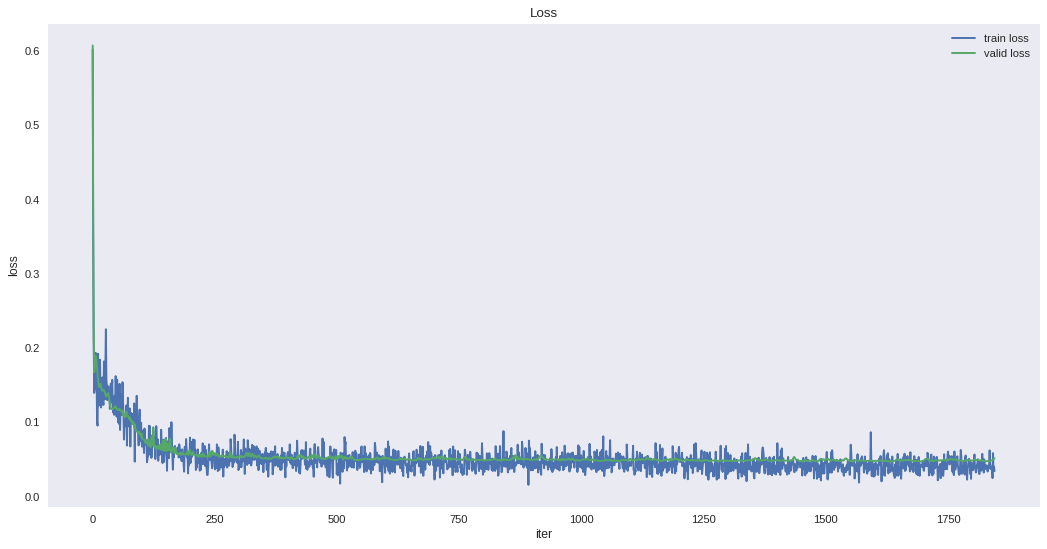

In [38]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

**Plot of ROC AUC vs iteration**

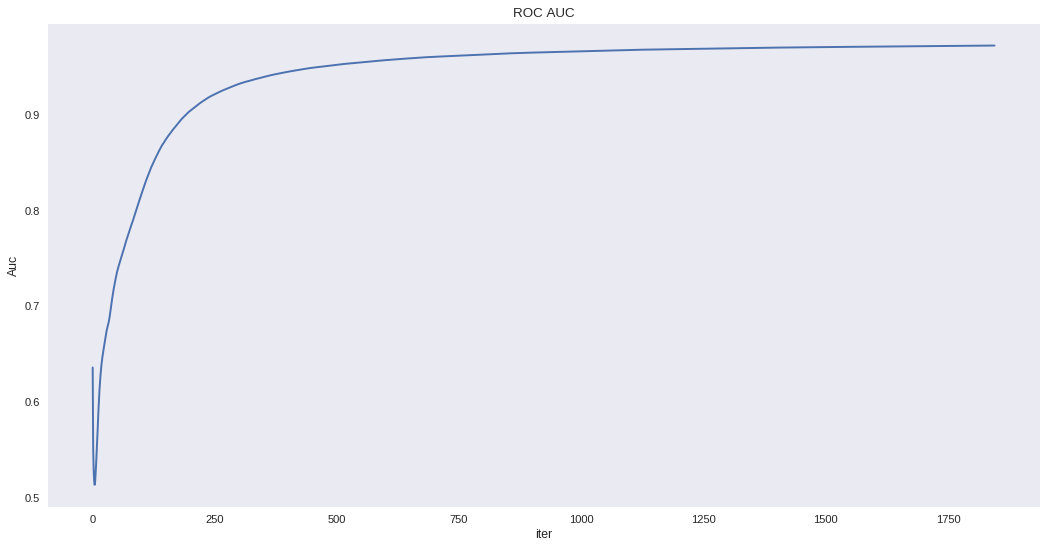

In [39]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_roc)
plt.title("ROC AUC")
plt.xlabel("iter")
plt.ylabel("Auc")
plt.grid()
plt.show()

# Create and Save submission file

In [0]:
del(comments_train, sentiments_train, seq_length_train, comments_validation, sentiments_validation, seq_length_validation)

**Create predictions matrix in folds and save the predictions in a csv file**

In [41]:
with tf.Session() as sess:  
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = len(test_id)
    k = 40
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        if i != (k-1):
            start = (step*i)
            end = (step*(i+1)) 
        else:
            start = (step*i)
            end = len(test_id)
            
        

        # feed dictionary for the fold
        feed_dict_test =  {X:sequence_generator(comments_test[start:end], max_length, size),
                            length:seq_length_test[start:end],
                            keep_prob: 1.0}

        # evaluate predictions of the fold
        fold_preds = logits.eval(session=sess, feed_dict = feed_dict_test)
        if i == 0:
            preds  = fold_preds
        else:
            preds = np.append(preds, fold_preds, axis=0)
        
        print("Computed predictions for fold",i)
        
    del(model, comments_test, seq_length_test)
    
    submission_matrix = np.append(np.transpose([test_id]), preds, axis=1)
    del(test_id)
    
    # save the submission csv file
    submission_path = "./submission.csv"
    columns = ["id","toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    submission = pd.DataFrame(submission_matrix, columns= columns)
    del(submission_matrix)
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-1844
Computed predictions for fold 0
Computed predictions for fold 1
Computed predictions for fold 2
Computed predictions for fold 3
Computed predictions for fold 4
Computed predictions for fold 5
Computed predictions for fold 6
Computed predictions for fold 7
Computed predictions for fold 8
Computed predictions for fold 9
Computed predictions for fold 10
Computed predictions for fold 11
Computed predictions for fold 12
Computed predictions for fold 13
Computed predictions for fold 14
Computed predictions for fold 15
Computed predictions for fold 16
Computed predictions for fold 17
Computed predictions for fold 18
Computed predictions for fold 19
Computed predictions for fold 20
Computed predictions for fold 21
Computed predictions for fold 22
Computed predictions for fold 23
Computed predictions for fold 24
Computed predictions for fold 25
Computed predictions for fold 26
Computed predictions for fold 27
Computed predictions for fol

**Save the submission file in google drive**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'submission.csv', 'parents':[{u'id': file_id_data["download_folder2_id"]}]})
uploaded.SetContentFile("submission.csv")
uploaded.Upload()